# Common part

- Dataset 1 (general): [link](https://mavenanalytics.io/data-playground)
- Dataset 2 (sentiment analysis): [link](https://huggingface.co/datasets/kcimc/NUFORC/tree/main)

In [4]:
%pip install --upgrade jupyter ipywidgets
# %jupyter nbextension enable --py widgetsnbextension # removed !pip on the recommendation of a comment.

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm  # Use tqdm.notebook for Jupyter

tqdm.pandas()  # Registers the progress_apply method

df = pd.read_csv(
    "../../../ufo_sightings_scrubbed.csv",
    low_memory=False
)

# Drop unnecessary columns
# df.drop(columns=['city', 'state', 'country', 'duration (hours/min)'], inplace=True)
df.drop(columns=['duration (hours/min)'], inplace=True)

# Rename columns
df.rename(columns={'duration (seconds)': 'duration'}, inplace=True)

# Fix missing states
df.loc[df['country'].isna() & df['state'].notna(), 'country'] = 'us'
df.dropna(subset=['country', 'state'], how='all', inplace=True)

# Fix dates
df['datetime'] = pd.to_datetime(df['datetime'])
df['date posted'] = pd.to_datetime(df['date posted'])

# Fix numbers
df['duration'] = pd.to_numeric(df['duration'], errors='coerce')
df['duration'].dropna(inplace=True)

# Swap datetime and date posted if datetime is greater than date posted
mask = df['datetime'].dt.date > df['date posted'].dt.date
df.loc[mask, ['datetime', 'date posted']] = df.loc[mask, ['date posted', 'datetime']].values


# Shape mapping
shape_mappings = {
    'cylinder': 'cylinder',
    'light': 'flash',
    'circle': 'disk',
    'sphere': 'sphere',
    'disk': 'disk',
    'fireball': 'fireball',
    'unknown': 'unknown',
    'oval': 'oval',
    'other': 'other',
    'cigar': 'cylinder',
    'rectangle': 'rectangle',
    'chevron': 'chevron',
    'triangle': 'triangle',
    'formation': 'formation',
    'delta': 'triangle',
    'changing': 'changing',
    'egg': 'oval',
    'diamond': 'diamond',
    'flash': 'flash',
    'teardrop': 'teardrop',
    'cone': 'cone',
    'cross': 'cross',
    'pyramid': 'other',
    'round': 'disk',
    'crescent': 'changing',
    'flare': 'flash',
    'hexagon': 'other',
    'dome': 'other',
    'changed': 'changing',
    np.nan: 'unknown'
}
df['shape'] = df['shape'].str.lower().map(shape_mappings)

# Remove incomplete year (2014)
df = df[df['datetime'].dt.year != 2014]

Note: you may need to restart the kernel to use updated packages.


# Part 2

- Dataset 2 (sentiment analysis): [link](https://huggingface.co/datasets/kcimc/NUFORC/tree/main)

## Alternative dataset

In [37]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import re

df = pd.read_csv(
    "../../../nuforc_bool.csv",
).rename(columns={
    'Sighting': 'Row ID',
    'Text': 'Comments',
    'Occurred': 'Datetime',
}).set_index('Row ID')

df.drop(columns=['Summary', 'Posted'], inplace=True)
df.rename(columns={ 'Reported': 'Date Posted' }, inplace=True)
df['Shape'] = df['Shape'].str.lower().map(shape_mappings)

# Convert headings to lowercase
df.columns = df.columns.str.lower()

# Fix dates
timezone_mapping = {
    "Pacific": "PST",    
    "Eastern": "EST",    
    "Central": "CST",    
    "Mountain": "MST",   
    "UTC": "UTC",
    "GMT": "GMT",
    "Local": "",  # Remove 'local' to keep datetime naive
}

def map_timezone(s):
    if pd.isna(s):
        return s
    # Extract last word
    last_word = re.findall(r'\b(\w+)$', s)
    if last_word and last_word[0] in timezone_mapping:
        # Replace last word with mapped timezone
        return re.sub(r'\b\w+$', timezone_mapping[last_word[0]], s)
    return s

# TODO there are outlier dates! e.g. 1639
df['datetime'] = pd.to_datetime(df['datetime'].apply(map_timezone), errors='coerce')
df['date posted'] = pd.to_datetime(df['date posted'].apply(map_timezone))

# Drop unnecessary columns and NAs
df.dropna(subset=['location', 'date posted', 'datetime'], inplace=True)

df_sent = df.dropna(subset=['comments']).copy()

/var/folders/gq/c0m9vgqx2_vflttb1fnkyw1r0000gn/T/ipykernel_35659/4137193267.py:44: FutureWarning: Parsed string "2014-10-23 11:11:17 PST" included an un-recognized timezone "PST". Dropping unrecognized timezones is deprecated; in a future version this will raise. Instead pass the string without the timezone, then use .tz_localize to convert to a recognized timezone.
  df['date posted'] = pd.to_datetime(df['date posted'].apply(map_timezone))


## NLT Pre-processing

In [41]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Only first time
# nltk.download('all')

df_sent = df.dropna(subset=['comments']).copy()

# Load resources once
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Updated preprocess_text function to handle all HTML-like codes
def preprocess_text(text, max_words=None):
    if not isinstance(text, str):
        return ""
    # Remove HTML-like codes using regex (e.g., &amp;, &#39;, etc.)
    text = re.sub(r'&[#a-zA-Z0-9]+;', ' ', text)
    # Tokenize and truncate
    tokens = word_tokenize(text.lower())
    # Truncate if max_words is specified
    if max_words is not None:
        tokens = tokens[:max_words]
    # Remove stopwords
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # Lemmatize
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
    processed_text = ' '.join(lemmatized_tokens)
    return processed_text

# Apply the updated function
df_sent['lemmatized comments'] = df_sent['comments'].progress_apply(lambda x: preprocess_text(x))

  0%|          | 0/130963 [00:00<?, ?it/s]

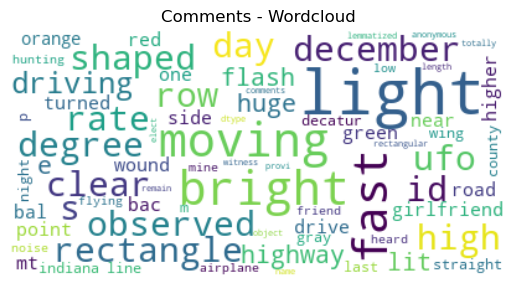

In [43]:
from wordcloud import WordCloud
from wordcloud import STOPWORDS
 
# Wordcloud with positive tweets
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(str(df_sent['lemmatized comments']).lower())
plt.figure()
plt.title("Comments - Wordcloud")
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## NLT Sentiment analysis

### Method 1: Sentiment Analysis with BoW Model (Vader)
Problem: since text is short, 95% is neutral and 3% is compound

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# initialize NLTK sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

def get_sentiment(text):
    scores = analyzer.polarity_scores(text)
    # Tresholding for sentiment
    sentiment = max(['pos', 'neu', 'neg'], key=lambda x: scores[x])
    return sentiment

# apply get_sentiment function
df_sent['sentiment'] = df_sent['comments'].apply(get_sentiment)

df_sent[['comments', 'sentiment']]

### Method 2: Sentiment Analsys with Pre-trained Transformer Model (BERT)

In [67]:
from transformers import pipeline

sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model="distilbert-base-uncased-finetuned-sst-2-english",
    top_k=1,
    truncation=True,
	max_length=512
)

df_sent_sample = df_sent.sample(n=5000, random_state=42)
df_sent_sample['sentiment'] = df_sent_sample['comments'].progress_apply(
    lambda x: sentiment_pipeline(x)[0][0]['label']
)

# Visualizza i risultati
df_sent_sample[['comments', 'sentiment']].head()

Device set to use mps:0


  0%|          | 0/5000 [00:00<?, ?it/s]

KeyboardInterrupt: 

### Method 3: Emotional Analysis with cherry-picking words

In [53]:
# Define a list of emotion-related keywords
emotion_keywords = [
    'fear', 'hopeful', 'shocked', 'confused', 'grateful',
    'scared', 'curious', 'sad', 'surprised', 'excited'
]

# Create a column for each emotion keyword (lemmatized)
for emotion in [lemmatizer.lemmatize(word) for word in emotion_keywords]:
    df_sent[emotion] = df_sent['lemmatized comments'].progress_apply(lambda x: emotion in x.lower() if isinstance(x, str) else False)

# Display the updated dataframe with the new emotion columns
df_sent[['comments'] + emotion_keywords]

# Count the number of rows for each emotion
df_sent[emotion_keywords].sum().sort_values()

  0%|          | 0/130963 [00:00<?, ?it/s]

  0%|          | 0/130963 [00:00<?, ?it/s]

  0%|          | 0/130963 [00:00<?, ?it/s]

  0%|          | 0/130963 [00:00<?, ?it/s]

  0%|          | 0/130963 [00:00<?, ?it/s]

  0%|          | 0/130963 [00:00<?, ?it/s]

  0%|          | 0/130963 [00:00<?, ?it/s]

  0%|          | 0/130963 [00:00<?, ?it/s]

  0%|          | 0/130963 [00:00<?, ?it/s]

  0%|          | 0/130963 [00:00<?, ?it/s]

grateful      255
sad           433
hopeful       494
confused      893
surprised    1234
shocked      1351
excited      1596
fear         1672
curious      1753
scared       3421
dtype: int64

### Method 4: Emotional Analsysis with model (RoBERTa)

In [58]:
from transformers import pipeline

# Use a faster emotion model and limit to 5,000 records
emotion_pipeline = pipeline(
    "text-classification",
    # model="cardiffnlp/twitter-roberta-base-emotion",
    model="j-hartmann/emotion-english-distilroberta-base", 
    top_k=1,
    truncation=True,
	max_length=512
)

# Limit records for speed
df_sent_sample = df_sent.sample(n=5000, random_state=42).copy()

# Apply the pipeline (truncate input for speed)
df_sent_sample['emotion'] = df_sent_sample['comments'].progress_apply(
    lambda x: emotion_pipeline(x)[0][0]['label']
)

df_sent_sample[['comments', 'emotion']]

Device set to use mps:0


  0%|          | 0/5000 [00:00<?, ?it/s]

AttributeError: 'str' object has no attribute 'sort_values'

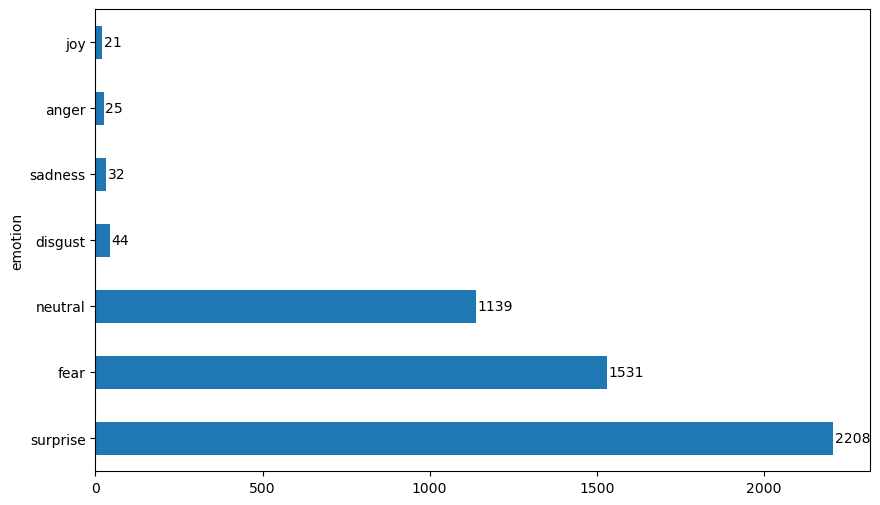

In [62]:
ax = df_sent_sample['emotion'].value_counts().sort_values(ascending=False).plot(kind='barh', figsize=(10, 6))

# Annotate each bar with its value
for i, v in enumerate(df_sent_sample['emotion'].value_counts().sort_values(ascending=False)):
    ax.text(v + 5, i, str(v), color='black', va='center')

plt.show()

## Visualizations (Method 2)
Chose this method because the others were too resource-intense and there are a lot of outliers in the text.

### Emotion vs Time of the Day
Apparently no relevant differences

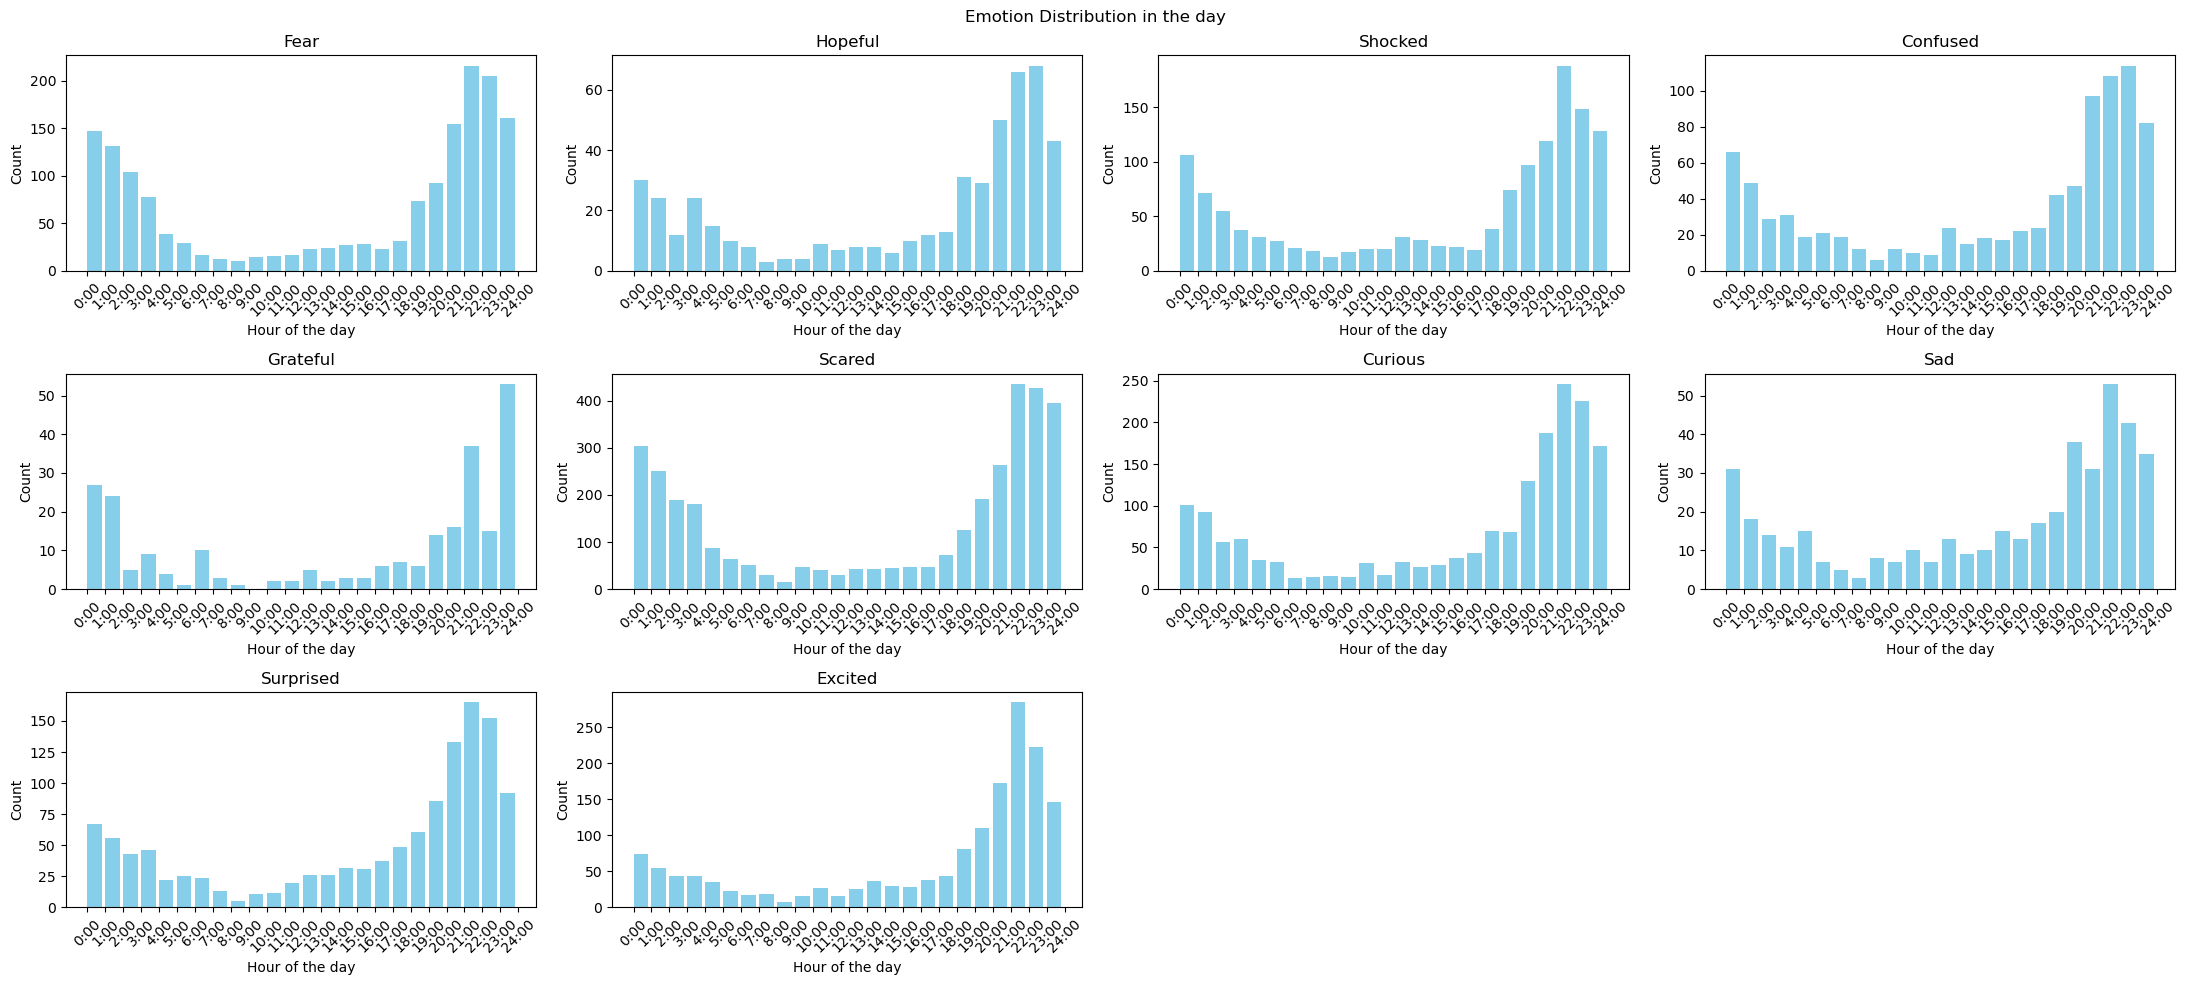

In [ ]:
fig, axes = plt.subplots(3, 4, figsize=(25, 10))

for e, ax in zip(emotion_keywords, axes.flatten()):
    # Filter the DataFrame for the current emotion
    df_emotion = df_sent[df_sent[e] == True]
    
    # Count occurrences by hour
    df_emotion_count = df_emotion['datetime'].dt.hour.value_counts().sort_index().reset_index()
    df_emotion_count.columns = ['hour', 'count']
    # Plot the histogram
    ax.bar(df_emotion_count['hour'], df_emotion_count['count'], color='skyblue', align="edge")
    ax.set_xticks(range(0, 25))
    ax.set_xticklabels([f"{h}:00" for h in range(0, 25)], rotation=45)
    ax.set_title(e.capitalize())
    ax.set_xlabel('Hour of the day')
    ax.set_ylabel('Count')

# Hide unused subplots
for ax in axes.flatten()[len(emotion_keywords):]:
    ax.axis('off')

plt.suptitle('Emotion Distribution in the day')
plt.tight_layout()
plt.show()

## Most occurring words (by feeling)
Apparently no relevant differences

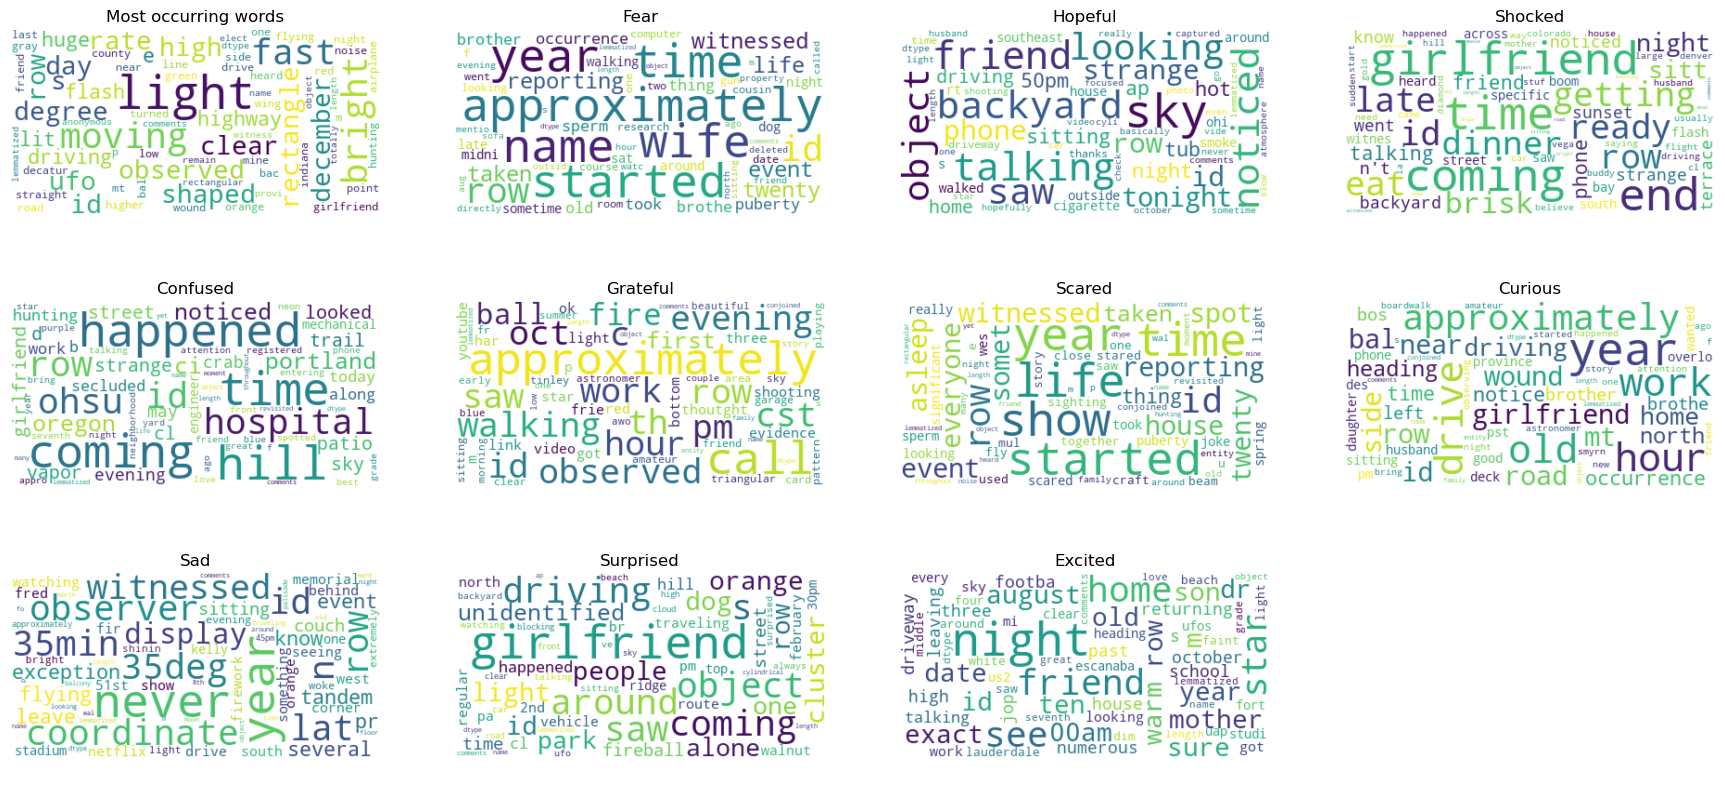

In [ ]:
from wordcloud import WordCloud
 
fig, axes = plt.subplots(3, 4, figsize=(22, 10))

wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(str(df_sent['lemmatized comments']).lower())
axes[0, 0].set_title('All')
axes[0, 0].imshow(wordcloud, interpolation="bilinear")
axes[0, 0].axis("off")

for ax, e in zip(axes.flatten()[1:], emotion_keywords):
    subset = df_sent[df_sent[e] == True]
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(str(subset['lemmatized comments']).lower())
    ax.set_title(e.capitalize())
    ax.imshow(wordcloud, interpolation="bilinear")
    ax.axis("off")

plt.axis("off")
plt.show()

## Shape by emotion

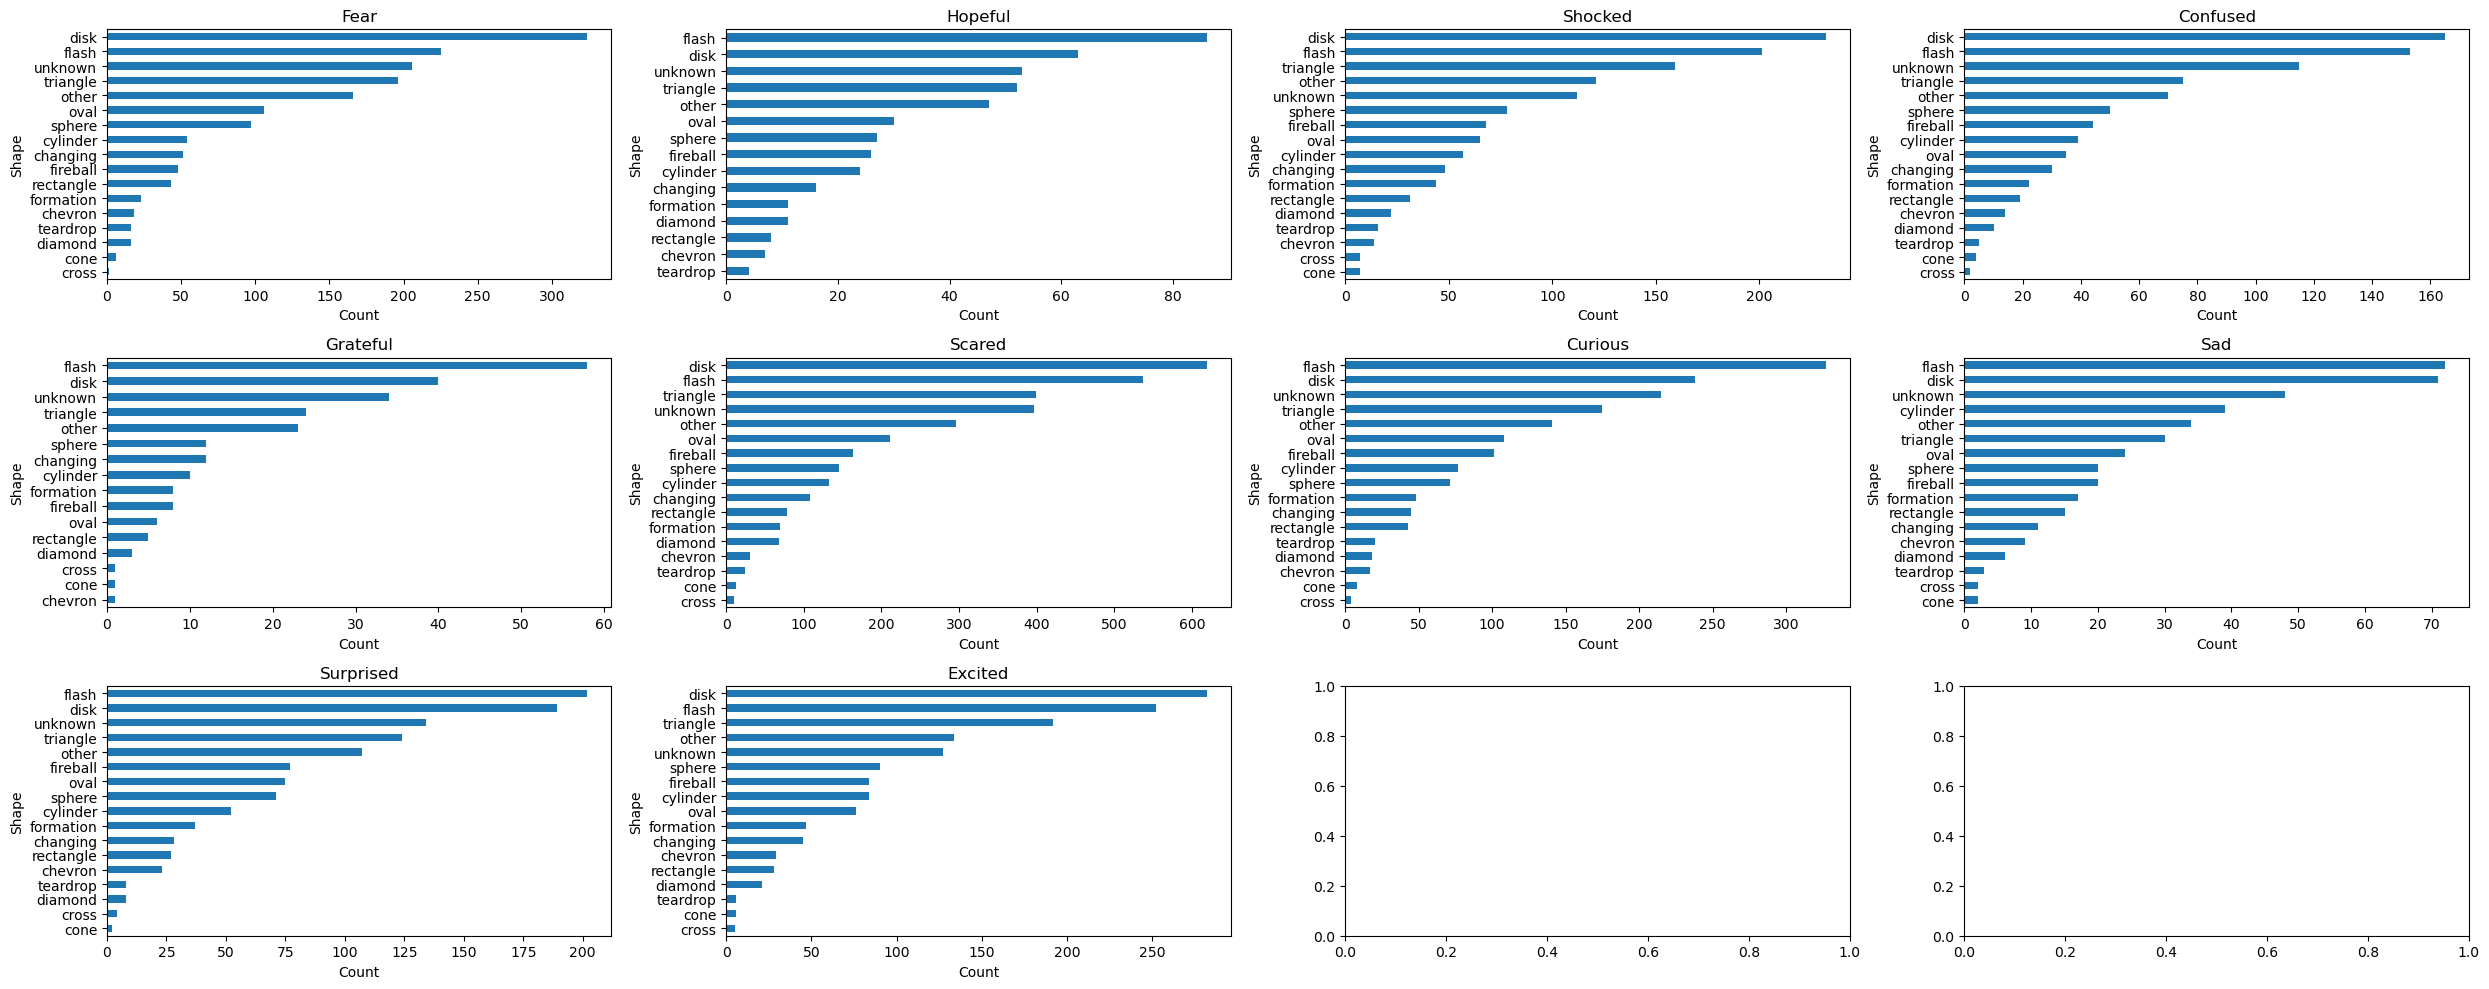

In [109]:
fig, axes = plt.subplots(3, 4, figsize=(25, 10))

for e, ax in zip(emotion_keywords, axes.flatten()):
    # Filter the DataFrame for the current emotion
    df_emotion = df_sent[df_sent[e] == True]
    df_emotion.groupby('shape')['shape'].count().sort_values(ascending=True).plot(kind='barh', ax=ax)
    ax.set_title(e.capitalize())
    ax.set_xlabel('Count')
    ax.set_ylabel('Shape')

plt.tight_layout()
plt.show()